<a href="https://colab.research.google.com/github/treyschulman/CNN_design_for_AD/blob/master/model_eval_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# ==============================
# 📌 Step 1: Mount Google Drive
# ==============================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import sys
sys.path.append('/content/drive/MyDrive/project/CNN_design_for_AD')

In [52]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import os

In [53]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from numpy import interp
import matplotlib.pyplot as plt
from numpy.random import permutation
import yaml

In [54]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Torch Device: {device}")
if device.type == 'cuda':
    print(f"GPU Model: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ No GPU detected - training will be very slow.")

✅ Torch Device: cpu
⚠️ No GPU detected - training will be very slow.


# Load Config

In [55]:
%cd /content/drive/MyDrive/project/CNN_design_for_AD

/content/drive/MyDrive/project/CNN_design_for_AD


In [56]:
config_name = 'config.yaml'
with open(config_name) as stream:
    try:
        cfg = yaml.safe_load(stream)
        print(cfg)
    except yaml.YAMLError as exc:
        print(exc)

{'NAME': 'CNN_ADNI', 'DATASET': 'ADNI', 'DIR_TO_DATASET': '/content/drive/MyDrive/project/cnn_input', 'DIR_TO_TSV': '/content/drive/MyDrive/project/CNN_design_for_AD/datasets/files', 'DIR_TO_LOGS': '/content/drive/MyDrive/project/CNN_design_for_AD/logs', 'DIR_TO_SAVE_MODEL': '/content/drive/MyDrive/project/CNN_design_for_AD/checkpoint', 'data': {'data_root_dir': '/content/drive/MyDrive/project/dir_to_scans/', 'dir_to_scans': '/content/drive/MyDrive/project/dir_to_scans/subjects', 'dir_to_tsv': '/content/drive/MyDrive/project/CNN_design_for_AD/datasets/files', 'batch_size': 4, 'val_batch_size': 2, 'workers': 4, 'percentage_usage': 1.0}, 'model': {'arch': 'ours', 'input_channel': 1, 'nhid': 512, 'feature_dim': 1024, 'n_label': 3, 'expansion': 8, 'num_blocks': 0, 'type_name': 'conv3x3x3', 'norm_type': 'Instance'}, 'adv_model': {'nhid': 36, 'out_dim': 12}, 'mmse_model': {'nhid': 64}, 'training_parameters': {'use_age': True, 'pretrain': None, 'max_iter': 16000, 'start_epoch': 0, 'epochs': 2

# Load Data

In [57]:
from datasets.adni_3d import ADNI_3D
from models.build_model import build_model

In [58]:
dir_to_scans = '/content/drive/MyDrive/project/dir_to_scans/subjects'
dir_to_tsv = './datasets/files'
Test_dataset = ADNI_3D(dir_to_scans, dir_to_tsv, mode = 'Test',  n_label = cfg['model']['n_label'])
Test_loader = torch.utils.data.DataLoader(
        Test_dataset, batch_size=cfg['data']['val_batch_size'], shuffle=False,
        num_workers=cfg['data']['workers'], pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [59]:
category = ['CN','MCI','AD']

In [60]:
def visualize_example(Test_dataset,sub_id):
    plt.figure(figsize=(10, 10))
    image = Test_dataset.__getitem__(sub_id)[0][0]
    plt.subplot(1, 3, 1)
    plt.imshow(np.rot90(image[26,:,:]),cmap = 'gray')
    plt.ylabel('Subject '+str(sub_id) + ' in Test dataset', fontsize=10)
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]] , fontsize=10)
    plt.subplot(1, 3, 2)
    plt.imshow(np.rot90(image[:,57,:]),cmap = 'gray')
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]], fontsize=10)
    plt.subplot(1, 3, 3)
    plt.imshow(np.rot90(image[:,:,50]),cmap = 'gray')
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]], fontsize=10)

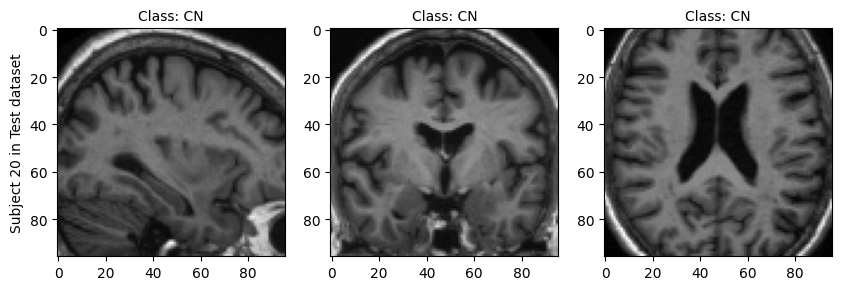

In [61]:
visualize_example(Test_dataset,20)

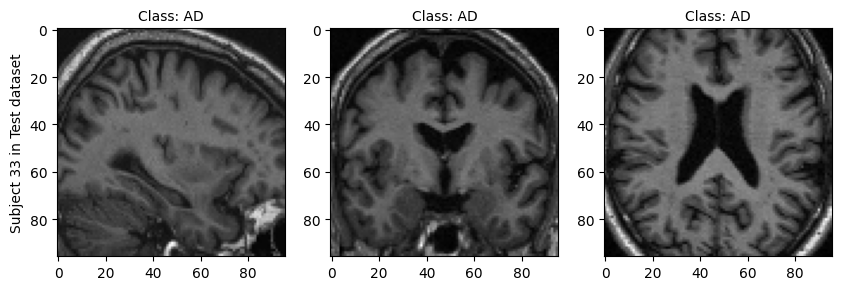

In [62]:
visualize_example(Test_dataset,33)

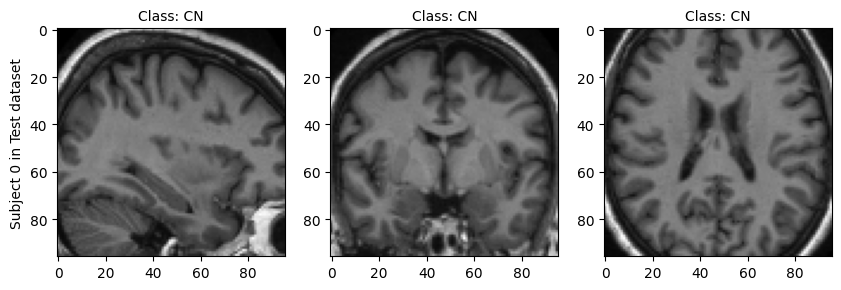

In [63]:
visualize_example(Test_dataset,0)

# Utility functions

In [64]:
from sklearn.metrics import confusion_matrix
def balanced_accuracy_score(y_true, y_pred, sample_weight=None,
                            adjusted=False):
    C = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)
    with np.errstate(divide='ignore', invalid='ignore'):
        per_class = np.diag(C) / C.sum(axis=1)
    if np.any(np.isnan(per_class)):
        warnings.warn('y_pred contains classes not in y_true')
        per_class = per_class[~np.isnan(per_class)]
    score = np.mean(per_class)
    if adjusted:
        n_classes = len(per_class)
        chance = 1 / n_classes
        score -= chance
        score /= 1 - chance
    return score

In [65]:
def calc_aucs(target_all,logit_all):
    y = label_binarize(target_all, classes=[0,1,2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for k in range(cfg['model']['n_label']):
        fpr[k], tpr[k], _ = roc_curve(y[:, k], logit_all[:, k])
        roc_auc[k] = auc(fpr[k], tpr[k])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), logit_all.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[k] for k in range(cfg['model']['n_label'])]))

    mean_tpr = np.zeros_like(all_fpr)
    for k in range(cfg['model']['n_label']):
        mean_tpr += interp(all_fpr, fpr[k], tpr[k])

    # Finally average it and compute AUC
    mean_tpr /= cfg['model']['n_label']

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return roc_auc

In [66]:
def plot_rocs(target_all,logit_all):
    y = label_binarize(target_all, classes=[0,1,2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for k in range(cfg['model']['n_label']):
        fpr[k], tpr[k], _ = roc_curve(y[:, k], logit_all[:, k])
        roc_auc[k] = auc(fpr[k], tpr[k])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), logit_all.ravel())
    roc_auc[k+1] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[k] for k in range(cfg['model']['n_label'])]))

    mean_tpr = np.zeros_like(all_fpr)
    for k in range(cfg['model']['n_label']):
        mean_tpr += interp(all_fpr, fpr[k], tpr[k])

    # Finally average it and compute AUC
    mean_tpr /= cfg['model']['n_label']

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc[k+2] = auc(fpr["macro"], tpr["macro"])
    plotting_fpr = []
    plotting_tpr = []
    for k in range(cfg['model']['n_label']):
        plotting_fpr.append(fpr[k])
        plotting_tpr.append(tpr[k])
    plotting_fpr += [fpr["micro"], fpr["macro"]]
    plotting_tpr += [tpr["micro"], tpr["macro"]]
    auc_outs = [plotting_fpr, plotting_tpr, roc_auc]
    name = ['CN vs all ','MCI vs all ', 'AD vs all ', 'Micro ', 'Macro ']
    from itertools import cycle
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','navy','deeppink'])
    plt.figure()
    for i, color in zip(range(len(auc_outs[0])), colors):
        plt.plot(auc_outs[0][i], auc_outs[1][i], color=color, lw=2, label=name[i] + 'ROC curve (area = %0.2f)' % auc_outs[2][i])
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC curves')
    plt.legend(loc="lower right")

# Functions for model evaluations

In [67]:
def run_epoch(model,val_loader,use_age=False):
    logit_all = []
    target_all = []
    mmse_all = []
    patient_idx_all = []
    cdr_all = []
    for i, (input, target, patient_idx, mmse, cdr_sub, age_id) in enumerate(val_loader):
        if i % 20 == 0:
            print('Iteration: ',i)
        input = input.to(device)
        target = target.to(device)
        if use_age:
            age_id = age_id.to(device)
        else:
            age_id = None
        logit = model(input,age_id)
        logit_all.append(logit.data.cpu())
        target_all.append(target.data.cpu())
        mmse_all.append(mmse.cpu())
        patient_idx_all.append(patient_idx.cpu())
        cdr_all.append(cdr_sub.cpu())

    logit_all_catted = torch.cat(logit_all)
    target_all_catted = torch.cat(target_all)
    mmse_all_catted = torch.cat(mmse_all)
    patient_idx_all_catted = torch.cat(patient_idx_all)
    cdr_all_catted = torch.cat(cdr_all)
    return logit_all_catted.numpy(), target_all_catted.numpy(), mmse_all_catted.numpy(), patient_idx_all_catted.numpy(), cdr_all_catted.numpy()

In [68]:
def evaluation_models(model_name,data_loader, expansion_list = [1],  num_trails = 10,percentage = 0.8, use_age = False, norm_type= 'Instance'):

    all_acc = np.zeros((len(expansion_list),num_trails))
    all_balanced_acc = np.zeros((len(expansion_list),num_trails))
    all_auc = []
    for i,ep in enumerate(expansion_list):
        cfg['model']['expansion'] = ep
        cfg['model']['norm_type'] = norm_type
        model = build_model(cfg)
        best_model_dir = './saved_model/'
        pretrained_dict = torch.load(best_model_dir+model_name + '_model_low_loss.pth.tar', map_location='cpu', weights_only=False)['state_dict']
        old_ks = list(pretrained_dict.keys()).copy()
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:]in model_dict.keys())}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
        model = model.to(device)
        model = model.eval()
        logit_all,target_all,_,_,_= run_epoch(model, data_loader, use_age)
        #print(F.softmax(torch.tensor(logit_all[0:20]),dim=1))
        tes_auc = []
        for tes in range(num_trails):
            rand_idex = permutation(range(len(target_all)))[:int(percentage*len(target_all))]
            target_test = target_all[rand_idex]
            pred_test = np.argmax(logit_all,1)[rand_idex]
            logit_test = logit_all[rand_idex]
            all_acc[i,tes] =accuracy_score(target_test, pred_test)
            all_balanced_acc[i,tes] =balanced_accuracy_score(target_test, pred_test)
            tes_auc.append(calc_aucs(target_test,logit_test))
        plot_rocs(target_test,logit_test)
        all_auc.append(tes_auc)
        print(old_ks)
        print(list(pretrained_dict.keys()))
    return all_acc, all_balanced_acc, all_auc

In [69]:
def test_model(all_acc, all_balanced_acc,all_auc):
    for w_k in range(len(all_acc)):
        print('Mean Acc ', np.mean(all_acc[w_k]),'\t')
        print('STD Acc ', np.std(all_acc[w_k]),'\t')
        print('Mean Balanced Acc ', np.mean(all_balanced_acc[w_k]),'\t')
        print('std Balanced Acc ', np.std(all_balanced_acc[w_k]),'\t')
        avg_micro = []
        avg_macro = []
        for d in all_auc[w_k]:
            avg_micro.append( d['micro'])
            avg_macro.append( d['macro'])
        print('Micro mean: ',np.mean(avg_micro))
        print('Micro std: ', np.std(avg_micro))
        print('Macro mean: ',np.mean(avg_macro))
        print('Macro std: ',np.std(avg_macro))

# Load model

In [70]:
from datasets.adni_3d import ADNI_3D
from torch.utils.data import DataLoader

# Extract relevant config paths
data_cfg = cfg["data"]
dir_to_scans = data_cfg["dir_to_scans"]
dir_to_tsv = data_cfg["dir_to_tsv"]
batch_size = data_cfg["batch_size"]
val_batch_size = data_cfg["val_batch_size"]
n_label = cfg["model"]["n_label"]
percentage_usage = data_cfg.get("percentage_usage", 1.0)

# Create dataset instances
Train_dataset = ADNI_3D(dir_to_scans, dir_to_tsv, mode="Train", n_label=n_label, percentage_usage=percentage_usage)
Val_dataset   = ADNI_3D(dir_to_scans, dir_to_tsv, mode="Val", n_label=n_label, percentage_usage=1.0)
Test_dataset  = ADNI_3D(dir_to_scans, dir_to_tsv, mode="Test", n_label=n_label, percentage_usage=1.0)

# Create DataLoaders
Train_loader = DataLoader(Train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
Val_loader   = DataLoader(Val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=4)
Test_loader  = DataLoader(Test_dataset, batch_size=val_batch_size, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [71]:
print(f"Train set size: {len(Train_loader.dataset)}")
print(f"Validation set size: {len(Val_loader.dataset)}")
print(f"Test set size: {len(Test_loader.dataset)}")

Train set size: 163
Validation set size: 36
Test set size: 36


In [48]:
from collections import Counter

from collections import Counter

def print_label_distribution(dataloader, name):
    labels = []
    total = len(dataloader.dataset)
    print(f"\n{name} set: scanning {total} samples...")

    for i in range(total):
        try:
            sample = dataloader.dataset[i]
            label = sample[1]  # second element is the label
            label_value = label if isinstance(label, int) else label.item()
            print(f"  ✅ Sample #{i} label: {label_value}")
            labels.append(label_value)
        except Exception as e:
            print(f"  ⚠️ Sample #{i} failed: {e}")
            continue

    print(f"{name} set label distribution: {Counter(labels)}")


print_label_distribution(Train_loader, "Train")
print_label_distribution(Val_loader, "Validation")
print_label_distribution(Test_loader, "Test")



Train set: scanning 163 samples...
  ✅ Sample #0 label: 0
  ✅ Sample #1 label: 0
  ✅ Sample #2 label: 2
  ✅ Sample #3 label: 2
  ✅ Sample #4 label: 2
  ✅ Sample #5 label: 0
  ✅ Sample #6 label: 0
  ✅ Sample #7 label: 0
  ✅ Sample #8 label: 0
  ✅ Sample #9 label: 0
  ✅ Sample #10 label: 0
  ✅ Sample #11 label: 2
  ✅ Sample #12 label: 0
  ✅ Sample #13 label: 0
  ✅ Sample #14 label: 2
  ✅ Sample #15 label: 2
  ✅ Sample #16 label: 0
  ✅ Sample #17 label: 0
  ✅ Sample #18 label: 0
  ✅ Sample #19 label: 2
  ✅ Sample #20 label: 0
  ✅ Sample #21 label: 2
  ✅ Sample #22 label: 0
  ✅ Sample #23 label: 2
  ✅ Sample #24 label: 0
  ✅ Sample #25 label: 0
  ✅ Sample #26 label: 2
  ✅ Sample #27 label: 2
  ✅ Sample #28 label: 2
  ✅ Sample #29 label: 0
  ✅ Sample #30 label: 2
  ✅ Sample #31 label: 0
  ✅ Sample #32 label: 0
  ✅ Sample #33 label: 0
  ✅ Sample #34 label: 0
  ✅ Sample #35 label: 0
  ✅ Sample #36 label: 0
  ✅ Sample #37 label: 2
  ✅ Sample #38 label: 0
  ✅ Sample #39 label: 2
  ✅ Sample #40

In [72]:
model = build_model(cfg)
# updated from hard-coded 'age_expansion_8' model which we should strive to create - from the research paper, using use_age=True improved the accuracy by 3 points or so
model_file_name = 'oasis_experiment_train_perc_100.0_expansion_0'

Iteration:  0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ran

['model.image_embedding_model.conv.conv0_s1.weight', 'model.image_embedding_model.conv.conv0_s1.bias', 'model.image_embedding_model.conv.conv1_s1.weight', 'model.image_embedding_model.conv.conv1_s1.bias', 'model.image_embedding_model.conv.conv2_s1.weight', 'model.image_embedding_model.conv.conv2_s1.bias', 'model.image_embedding_model.conv.conv3_s1.weight', 'model.image_embedding_model.conv.conv3_s1.bias', 'model.image_embedding_model.fc6.fc6_s1.weight', 'model.image_embedding_model.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.pe', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.weight', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.weight', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.bias', 'model.image_embedding_model.age_encoder.fc6.fc6_s3.weight', 'model.image_embedding_model.age_encoder.fc6.fc6_s3.bias', 'model.classifier.classifier.LinearClassifier.weight', 'model.classifier.classifier.Lin

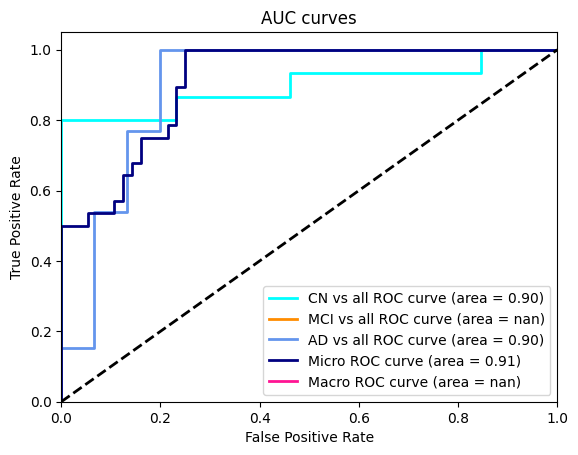

In [73]:
all_acc, all_balanced_acc, all_auc = evaluation_models(model_file_name, Test_loader, expansion_list = [8], use_age = False, norm_type= 'Instance')

In [74]:
test_model(all_acc, all_balanced_acc,all_auc)

Mean Acc  0.6857142857142857 	
STD Acc  0.04164965639175215 	
Mean Balanced Acc  0.6557813999725765 	
std Balanced Acc  0.04091111990633622 	
Micro mean:  0.9135841836734693
Micro std:  0.015138457755577647
Macro mean:  nan
Macro std:  nan


## Previous Run to Compare

Iteration:  0
Iteration:  20
Iteration:  40
Iteration:  60
Iteration:  80
Iteration:  100
Iteration:  120
Iteration:  140
Iteration:  160
Iteration:  180
['model.image_embedding_model.conv.conv0_s1.weight', 'model.image_embedding_model.conv.conv0_s1.bias', 'model.image_embedding_model.conv.conv1_s1.weight', 'model.image_embedding_model.conv.conv1_s1.bias', 'model.image_embedding_model.conv.conv2_s1.weight', 'model.image_embedding_model.conv.conv2_s1.bias', 'model.image_embedding_model.conv.conv3_s1.weight', 'model.image_embedding_model.conv.conv3_s1.bias', 'model.image_embedding_model.fc6.fc6_s1.weight', 'model.image_embedding_model.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.pe', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.weight', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.weight', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.bias', 'model.image_embedding_model.age_encoder.fc6.fc6_s3.w

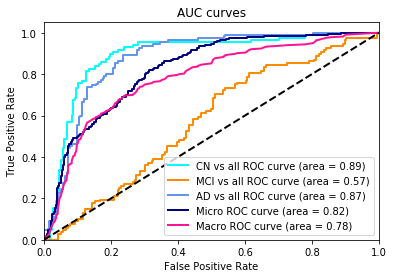

In [ ]:
all_acc, all_balanced_acc, all_auc = evaluation_models(model_file_name, Test_loader, expansion_list = [8], use_age = True, norm_type= 'Instance')

## Statistics created by the Research Paper

In [ ]:
test_model(all_acc, all_balanced_acc,all_auc)

Mean Acc  0.68125 	
STD Acc  0.007565789473684216 	
Mean Balanced Acc  0.6965590032569433 	
std Balanced Acc  0.007475431973422053 	
Micro mean:  0.8242625735803324
Micro std:  0.004859012158648881
Macro mean:  0.7856490801930776
Macro std:  0.005688730409962248
